In [1]:
import sys
import numpy
from scipy.fftpack import dct
import scipy.io.wavfile
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#from matplotlib import rc
#rc('xtick', labelsize=18)
#rc('ytick', labelsize=18)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
sample_rate, signal = scipy.io.wavfile.read('OSR_us_000_0010_8k.wav')  # File assumed to be in the same directory 
signal = signal[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds

In [3]:
T = signal.shape[0] / float(sample_rate)
t = numpy.arange(signal.shape[0]) / float(sample_rate)

In [4]:
print sample_rate, signal.shape
print T
print t

8000 (28000,)
3.5
[  0.00000000e+00   1.25000000e-04   2.50000000e-04 ...,   3.49962500e+00
   3.49975000e+00   3.49987500e+00]


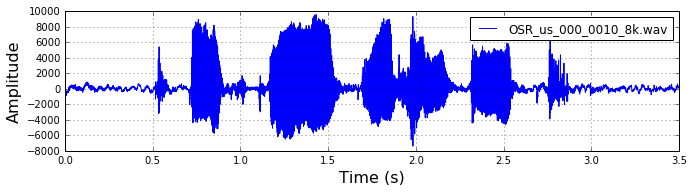

In [5]:
plt.figure(figsize=(11, 2.5))
plt.plot(t, signal, label='OSR_us_000_0010_8k.wav')
plt.ylabel('Amplitude', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.legend()
plt.grid(True)
plt.ylim([-8000,10000])
plt.savefig('time_signal.jpg', bbox_inches='tight', dpi=200)
plt.show()

In [6]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

In [7]:
print emphasized_signal.shape

(28000,)


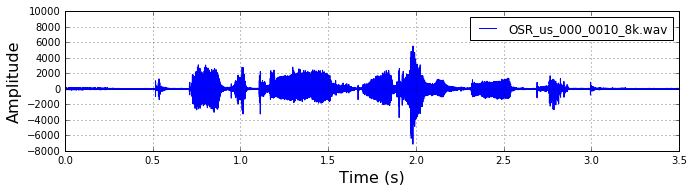

In [8]:
plt.figure(figsize=(11, 2.5))
plt.plot(t, emphasized_signal, label='OSR_us_000_0010_8k.wav')
plt.ylabel('Amplitude', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.legend()
plt.grid(True)
plt.ylim([-8000,10000])
plt.savefig('emphasized_time_signal.jpg', bbox_inches='tight', dpi=200)
plt.show()

In [9]:
frame_size = 0.025  # in Seconds
frame_stride = 0.01  # in Seconds

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

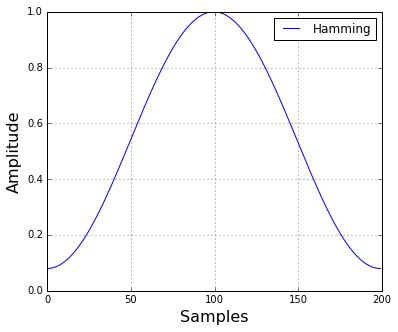

In [10]:
n = numpy.arange(frame_length)
h = 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length-1))
plt.figure(figsize=(6, 5))
plt.plot(h, label='Hamming')
plt.ylabel('Amplitude', fontsize=16)
plt.xlabel('Samples', fontsize=16)
plt.legend()
plt.grid(True)
plt.savefig('hamming_window.jpg', bbox_inches='tight', dpi=200)
plt.show()

In [11]:
frames *= numpy.hamming(frame_length)

In [12]:
print num_frames, frames.shape
print frames

348 (348, 200)
[[ -7.35200000e+01  -3.39024822e+01   1.82532225e+01 ...,   4.00781146e+00
    8.28286973e+00   3.96080000e+00]
 [ -3.69760000e+00   1.50991484e+00  -2.92595320e+00 ...,   3.32163659e+00
   -1.92710704e+00  -1.52560000e+00]
 [  1.23600000e+00  -2.23278056e+00  -1.89588174e+00 ...,  -1.98246276e-01
    6.99759684e+00   6.12720000e+00]
 ..., 
 [ -1.96800000e-01   2.68366905e+00   2.05852460e+00 ...,   2.30613015e-01
   -3.74670686e+00  -2.86000000e+00]
 [ -1.95040000e+00  -8.29570641e-01  -2.33445105e+00 ...,   3.98920058e+00
    1.49146211e+00   2.31360000e+00]
 [ -1.40320000e+00  -4.05157808e-01   3.90828373e-01 ...,   3.88400868e-02
    2.01535924e+00  -1.07920000e+00]]


In [13]:
NFFT = 512

# Power Spectrum
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * numpy.square(mag_frames))  # Power Spectrum

In [14]:
print mag_frames.shape, pow_frames.shape

(348, 257) (348, 257)


In [15]:
nfilt = 40

# FilterBanks
low_freq_mel = 0
high_freq_mel = (2595.0 * numpy.log10(1.0 + (sample_rate / 2.0) / 700.0))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700.0 * (10.0 ** (mel_points / 2595.0) - 1.0))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)  # FFT bins

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for j in xrange(0,nfilt):  # Loop over filters
    for i in xrange(int(bin[j]), int(bin[j + 1])):  # positive side
        fbank[j, i] = (i - bin[j]) / (bin[j + 1] - bin[j])
    for i in xrange(int(bin[j + 1]), int(bin[j + 2])):  # negative side
        fbank[j, i] = (bin[j + 2] - i) / (bin[j + 2] - bin[j + 1])

In [16]:
print sample_rate
print bin
print fbank.shape
print hz_points
print fbank[39,]

8000
[   0.    2.    4.    6.    9.   11.   14.   17.   20.   23.   26.   29.
   33.   37.   41.   45.   49.   53.   58.   63.   68.   74.   79.   85.
   91.   98.  105.  112.  119.  127.  135.  144.  153.  162.  172.  183.
  194.  205.  217.  229.  242.  256.]
(40, 257)
[    0.            33.27818895    68.13843198   104.65594038   142.90950098
   182.98164618   224.95883198   268.93162452   314.99489549   363.2480268
   413.79512499   466.74524587   522.2126298    580.31694812   641.18356143
   704.94378996   771.73519696   841.70188548   914.99480927   991.77209843
  1072.19940064  1156.45023851  1244.70638395  1337.15825037  1434.00530347
  1535.45649162  1641.73069664  1753.05720605  1869.67620777  1991.83930831
  2119.81007563  2253.86460776  2394.29212854  2541.39561156  2695.49243387
  2856.91506071  3026.01176279  3203.14736774  3388.70404717  3583.08214122
  3786.70102232  4000.        ]
[ 0.          0.          0.          0.          0.          0.          0.
  0.        

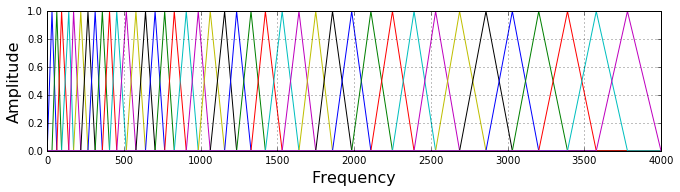

In [17]:
plt.figure(figsize=(11, 2.5))
plt.plot(numpy.linspace(low_freq_mel, (sample_rate / 2), 257), fbank.T)
plt.ylabel('Amplitude', fontsize=16)
plt.xlabel('Frequency', fontsize=16)
plt.grid(True)
plt.savefig('mel_filters.jpg', bbox_inches='tight', dpi=200)
plt.show()

In [18]:
# Features
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks) # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

In [19]:
print filter_banks.shape

(348, 40)


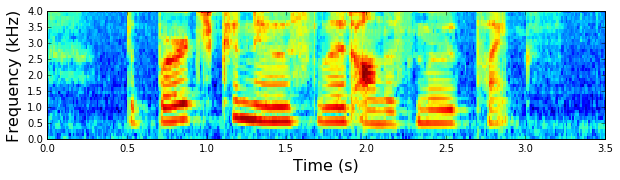

In [20]:
plt.imshow(numpy.flipud(filter_banks.T), cmap=cm.jet, aspect=0.2, extent=[0,T,0,4])
plt.ylabel('Frequency (kHz)', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.savefig('filter_banks_raw.jpg', bbox_inches='tight', dpi=200)
plt.show()

In [21]:
numceps = 13

mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : numceps]

[[ 66.48355744  54.76011962  49.63745583 ...,  78.64450774  71.99949403
   78.99093178]
 [ 61.23301363  52.91608023  56.99083717 ...,  75.83417962  73.71506105
   80.62107791]
 [ 64.4089059   48.14534052  45.0122096  ...,  82.7346298   80.16663478
   81.85881309]
 ..., 
 [ 56.46334726  57.08500675  57.69191529 ...,  56.13286897  51.92495349
   47.55649573]
 [ 61.64337067  57.71358112  64.34304082 ...,  50.58091266  51.48988482
   47.66323684]
 [ 63.19550752  57.6644685   62.88928695 ...,  50.50725165  51.30869935
   43.61620137]]


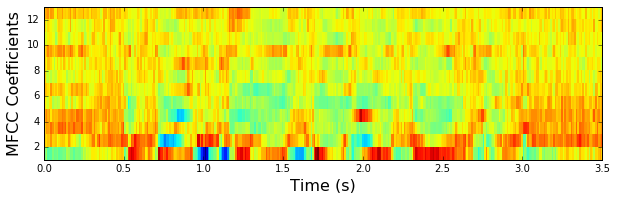

In [22]:
plt.imshow(numpy.flipud(mfcc.T), cmap=cm.jet, aspect=0.08, extent=[0,T,1,numceps])
plt.ylabel('MFCC Coefficients', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.savefig('mfcc_raw.jpg', bbox_inches='tight', dpi=200)
plt.show
print filter_banks

In [23]:
cep_lifter = 22

# Lifter
if cep_lifter > 0:
    (nframes, ncoeff) = numpy.shape(mfcc)
    n = numpy.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
    mfcc *= lift

[[ 66.48355744  54.76011962  49.63745583 ...,  78.64450774  71.99949403
   78.99093178]
 [ 61.23301363  52.91608023  56.99083717 ...,  75.83417962  73.71506105
   80.62107791]
 [ 64.4089059   48.14534052  45.0122096  ...,  82.7346298   80.16663478
   81.85881309]
 ..., 
 [ 56.46334726  57.08500675  57.69191529 ...,  56.13286897  51.92495349
   47.55649573]
 [ 61.64337067  57.71358112  64.34304082 ...,  50.58091266  51.48988482
   47.66323684]
 [ 63.19550752  57.6644685   62.88928695 ...,  50.50725165  51.30869935
   43.61620137]]


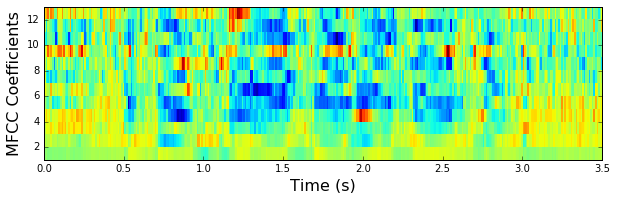

In [24]:
plt.imshow(numpy.flipud(mfcc.T), cmap=cm.jet, aspect=0.08, extent=[0,T,1,numceps])
plt.ylabel('MFCC Coefficients', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.savefig('mfcc_liftered.jpg', bbox_inches='tight', dpi=200)
plt.show
print filter_banks

In [25]:
filter_banks -= (numpy.mean(filter_banks, axis=0) + numpy.finfo(float).eps)

[[  7.95389889e+00   3.33413480e-02  -9.73383097e+00 ...,   5.23659251e+00
   -2.07923499e+00   6.74502249e-01]
 [  2.70335508e+00  -1.81069804e+00  -2.38044963e+00 ...,   2.42626439e+00
   -3.63667965e-01   2.30464838e+00]
 [  5.87924735e+00  -6.58143776e+00  -1.43590772e+01 ...,   9.32671457e+00
    6.08790576e+00   3.54238356e+00]
 ..., 
 [ -2.06631129e+00   2.35822847e+00  -1.67937151e+00 ...,  -1.72750463e+01
   -2.21537755e+01  -3.07599338e+01]
 [  3.11371212e+00   2.98680284e+00   4.97175402e+00 ...,  -2.28270026e+01
   -2.25888442e+01  -3.06531927e+01]
 [  4.66584898e+00   2.93769023e+00   3.51800015e+00 ...,  -2.29006636e+01
   -2.27700297e+01  -3.47002282e+01]]


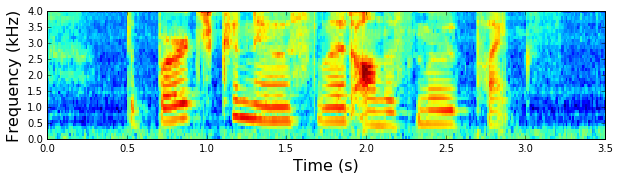

In [26]:
plt.imshow(numpy.flipud(filter_banks.T), cmap=cm.jet, aspect=0.2, extent=[0,T,0,4])
plt.ylabel('Frequency (kHz)', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.savefig('filter_banks.jpg', bbox_inches='tight', dpi=200)
plt.show
print filter_banks

In [27]:
mfcc -= (numpy.mean(mfcc, axis=0) + numpy.finfo(float).eps)

(348, 12)


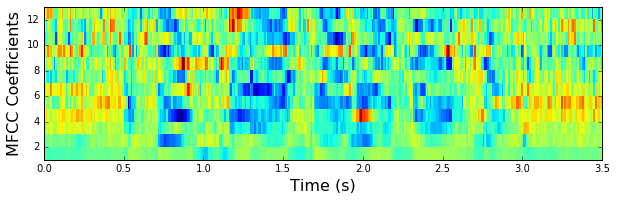

In [28]:
plt.imshow(numpy.flipud(mfcc.T), cmap=cm.jet, aspect=0.08, extent=[0,T,1,numceps])
plt.ylabel('MFCC Coefficients', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.savefig('mfcc.jpg', bbox_inches='tight', dpi=200)
plt.show
print mfcc.shape